In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
file_path = "final_dataset.csv" 
df = pd.read_csv(file_path)

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0.1     2106 non-null   int64         
 1   Unnamed: 0       2106 non-null   int64         
 2   date             2106 non-null   datetime64[ns]
 3   demand           2106 non-null   float64       
 4   RRP              2106 non-null   float64       
 5   demand_pos_RRP   2106 non-null   float64       
 6   RRP_positive     2106 non-null   float64       
 7   demand_neg_RRP   2106 non-null   float64       
 8   RRP_negative     2106 non-null   float64       
 9   frac_at_neg_RRP  2106 non-null   float64       
 10  min_temperature  2106 non-null   float64       
 11  max_temperature  2106 non-null   float64       
 12  solar_exposure   2106 non-null   float64       
 13  rainfall         2106 non-null   float64       
 14  school_day       2106 non-null   int64  

In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,weekday
0,0,0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,0,1,3
1,1,1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,1,0,4
2,2,2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,0,1,5
3,3,3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,0,1,6
4,4,4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,1,0,0


## Prophet model forecast With adding Regressors

In [7]:
df_prophet = df[['date', 'demand', 'holiday', 'school_day', 'min_temperature', 'max_temperature', 'rainfall']]
df_prophet = df_prophet.rename(columns={'date': 'ds', 'demand': 'y'})

In [8]:
model = Prophet(
    changepoint_prior_scale=0.05,  # Controls flexibility, lower = less overfitting
    seasonality_mode='multiplicative',  # Try 'multiplicative' for seasonality
    yearly_seasonality=True,  # Enable yearly patterns
    weekly_seasonality=True,  # Enable weekly patterns
    daily_seasonality=False  # Disable daily seasonality to avoid noise
)

In [9]:
model.add_regressor('holiday')
model.add_regressor('school_day')
model.add_regressor('min_temperature')
model.add_regressor('max_temperature')
model.add_regressor('rainfall')

In [10]:
model.fit(df_prophet)

17:16:55 - cmdstanpy - INFO - Chain [1] start processing
17:16:56 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = model.make_future_dataframe(periods=30, freq='D')

In [12]:
future = future.merge(df[['date', 'holiday', 'school_day', 'min_temperature', 'max_temperature', 'rainfall']], 
                      left_on='ds', right_on='date', how='left')
future.drop(columns=['date'], inplace=True)

In [13]:
future.fillna(method='ffill', inplace=True)

C:\Users\gobbu\AppData\Local\Temp\ipykernel_14732\3260383001.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='ffill', inplace=True)


In [14]:
forecast = model.predict(future)

In [15]:
df_results = df_prophet.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

In [16]:
y_true = df_results['y']
y_pred = df_results['yhat']

In [17]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
print(f"Optimized MAE: {mae}")
print(f"Optimized RMSE: {rmse}")
print(f"Optimized MAPE: {mape:.2f}%")

Optimized MAE: 5907.739694332754
Optimized RMSE: 7594.935334115009
Optimized MAPE: 4.92%


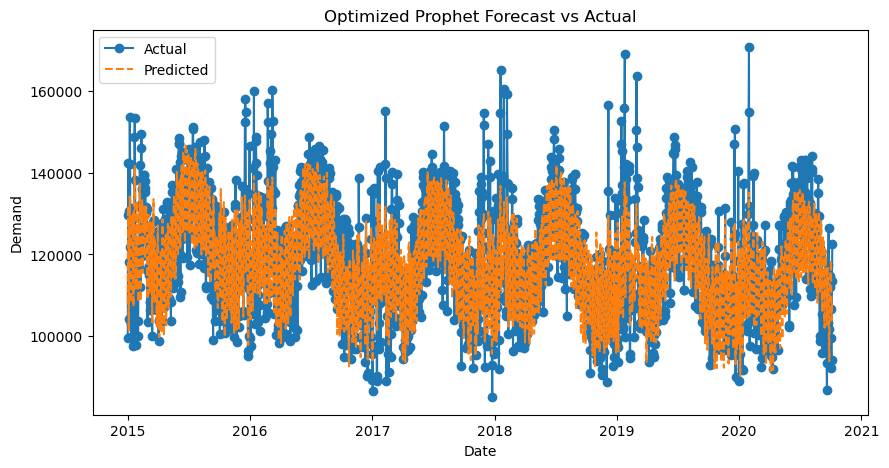

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(df_results['ds'], df_results['y'], label="Actual", marker='o')
plt.plot(df_results['ds'], df_results['yhat'], label="Predicted", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Optimized Prophet Forecast vs Actual")
plt.legend()
plt.show()

## Prophet model forecast Without adding Regressors

In [21]:
model_no_reg = Prophet(
    changepoint_prior_scale=0.03, 
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

In [22]:
model_no_reg.fit(df_prophet)

17:16:57 - cmdstanpy - INFO - Chain [1] start processing
17:16:57 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future_no_reg = model_no_reg.make_future_dataframe(periods=30, freq='D')

In [24]:
forecast_no_reg = model_no_reg.predict(future_no_reg)

In [25]:
df_eval_no_reg = df_prophet[['ds', 'y']].merge(forecast_no_reg[['ds', 'yhat']], on='ds', how='left')
mae_no_reg = mean_absolute_error(df_eval_no_reg['y'], df_eval_no_reg['yhat'])
rmse_no_reg = np.sqrt(mean_squared_error(df_eval_no_reg['y'], df_eval_no_reg['yhat']))
mape_no_reg = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
print(f"MAE (No Regressors): {mae_no_reg:.2f}")
print(f"RMSE (No Regressors): {rmse_no_reg:.2f}")
print(f"mape (No Regressors): {mape_no_reg:.2f}")

MAE (No Regressors): 6212.10
RMSE (No Regressors): 8675.32
mape (No Regressors): 4.92


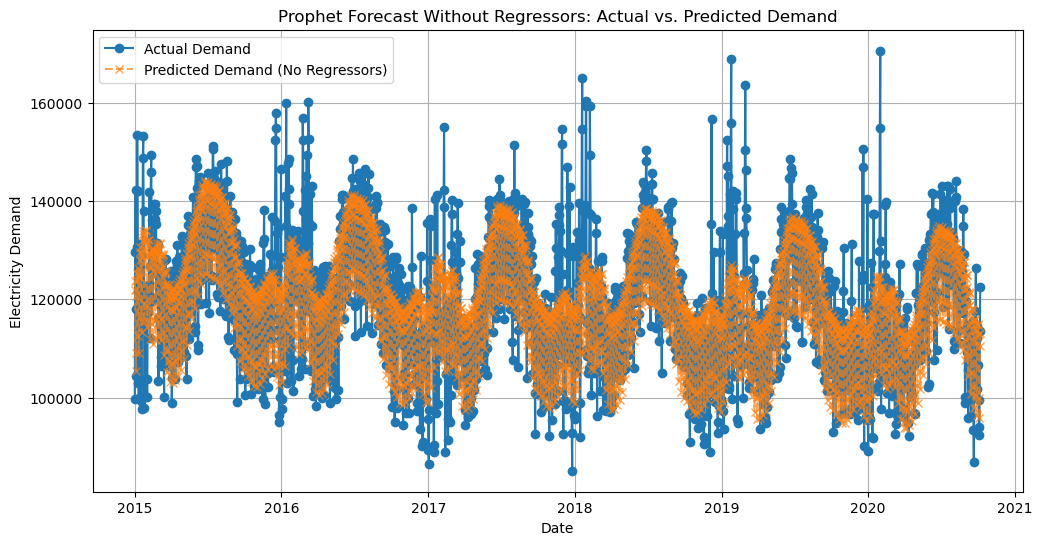

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df_eval_no_reg['ds'], df_eval_no_reg['y'], label='Actual Demand', marker='o', linestyle='-')
plt.plot(df_eval_no_reg['ds'], df_eval_no_reg['yhat'], label='Predicted Demand (No Regressors)', marker='x', linestyle='--', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Electricity Demand")
plt.title("Prophet Forecast Without Regressors: Actual vs. Predicted Demand")
plt.legend()
plt.grid(True)
plt.show()

## BY USING THESE EVALUATION METRICES: *Mean Absolute Error (MAE)*, *Root Mean Squared Error (RMSE)*, *Mean Absolute Percentage Error (MAPE)*
## here we can see the evaluation score with and without adding regressors
### this score is with adding regressors
**MAE:** 5917.864197788589,
**RMSE:** 7581.933929535785, 
**MAPE:** 4.93%
### this score is without adding regressors
**MAE (No Regressors):** 6212.10,
**RMSE (No Regressors):** 8675.32,
**MAPE (No Regressors):** 4.93%

## Future forecast prediction for 1 year

In [30]:
df_prophet = df[['date', 'demand']].copy()
df_prophet.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [31]:
model = Prophet()
model.fit(df_prophet)

17:16:58 - cmdstanpy - INFO - Chain [1] start processing
17:16:58 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
future = model.make_future_dataframe(periods=365)

In [33]:
forecast = model.predict(future)

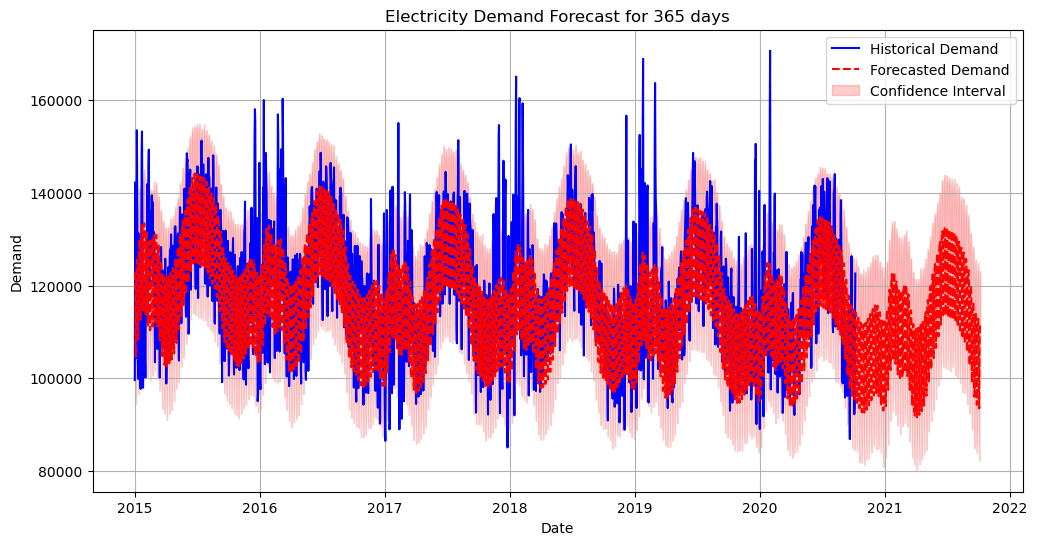

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_prophet['ds'], df_prophet['y'], label='Historical Demand', color='blue')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecasted Demand', color='red', linestyle='dashed')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2, label='Confidence Interval')
ax.set_title("Electricity Demand Forecast for 365 days")
ax.set_xlabel("Date")
ax.set_ylabel("Demand")
ax.legend()
plt.grid()
plt.show()

In [35]:
def forecast_demand(model, days):
    future = model.make_future_dataframe(periods=days, freq='D')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(days)
num_days = int(input("Enter the number of days for forecast: "))
forecast_result = forecast_demand(model, num_days)
print(forecast_result)

Enter the number of days for forecast:  365


             ds           yhat     yhat_lower     yhat_upper
2106 2020-10-07  113896.214184  103392.364557  124706.331521
2107 2020-10-08  114141.499098  102637.350233  124888.241501
2108 2020-10-09  112077.292163  100654.202153  122321.423555
2109 2020-10-10   98871.830879   87070.748507  110187.494163
2110 2020-10-11   94689.909069   82971.487988  106366.245020
...         ...            ...            ...            ...
2466 2021-10-02   97659.368151   87087.091798  109160.434160
2467 2021-10-03   93532.027959   81822.901280  104841.986580
2468 2021-10-04  108291.715745   97004.267659  119857.348713
2469 2021-10-05  110979.609205  100172.449654  122484.916829
2470 2021-10-06  111940.820292  101819.991878  123569.640983

[365 rows x 4 columns]


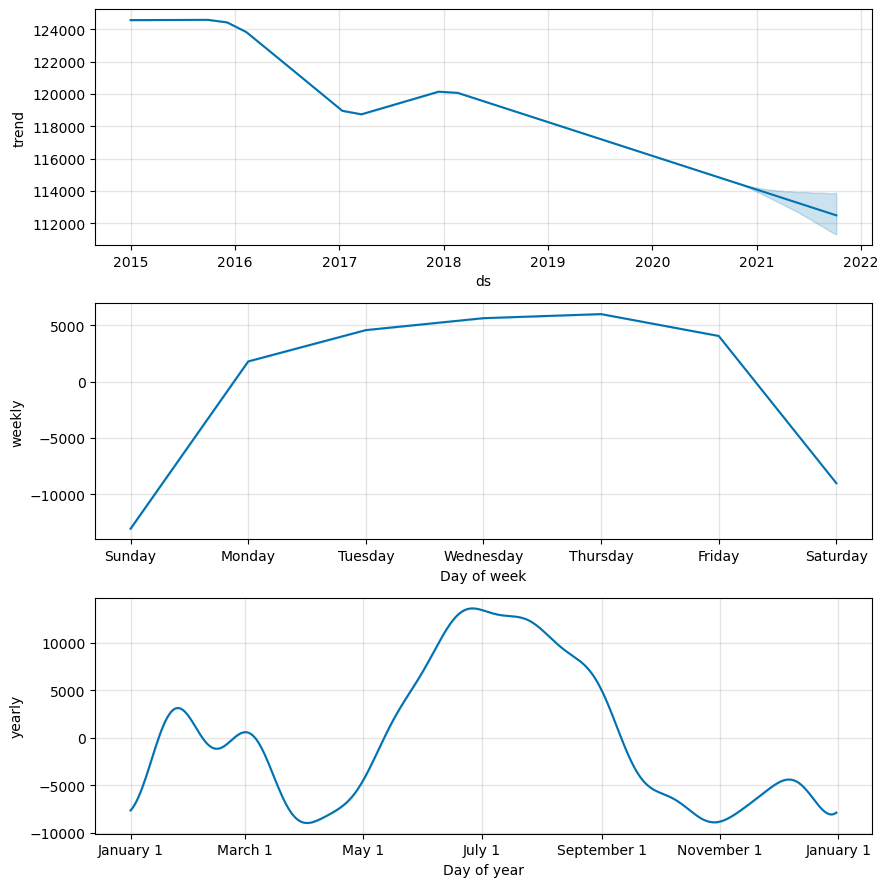

In [36]:
fig2 = model.plot_components(forecast)
plt.show()

## Future forecast prediction for 2 years

In [38]:
df_prophet = df[['date', 'demand']].copy()
df_prophet.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [39]:
model = Prophet()
model.fit(df_prophet)

17:17:34 - cmdstanpy - INFO - Chain [1] start processing
17:17:34 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
future = model.make_future_dataframe(periods=730)

In [41]:
forecast = model.predict(future)

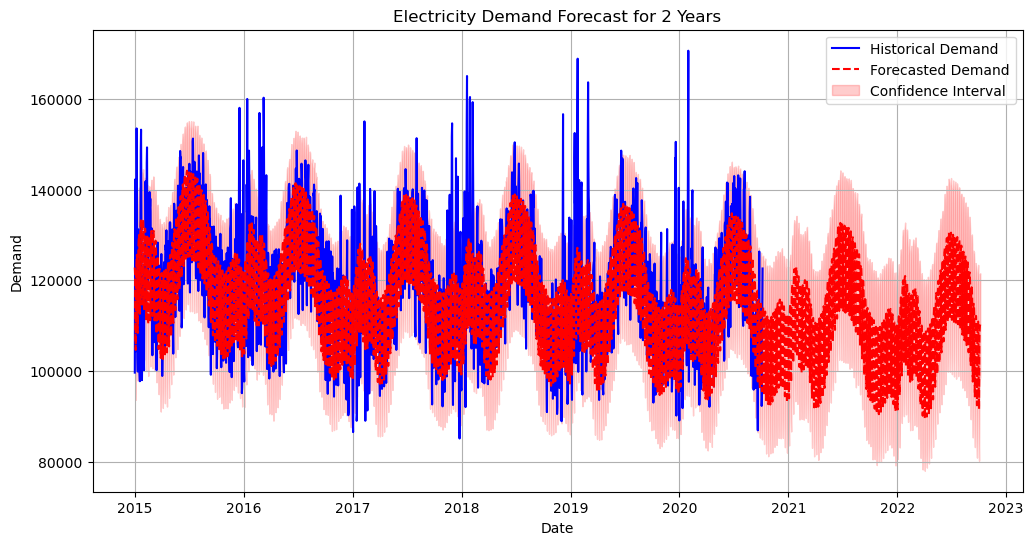

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_prophet['ds'], df_prophet['y'], label='Historical Demand', color='blue')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecasted Demand', color='red', linestyle='dashed')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2, label='Confidence Interval')
ax.set_title("Electricity Demand Forecast for 2 Years")
ax.set_xlabel("Date")
ax.set_ylabel("Demand")
ax.legend()
plt.grid()
plt.show()

In [43]:
def forecast_demand(model, days):
    future = model.make_future_dataframe(periods=days, freq='D')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(days)
num_days = int(input("Enter the number of days for forecast: "))
forecast_result = forecast_demand(model, num_days)
print(forecast_result)

Enter the number of days for forecast:  730


             ds           yhat     yhat_lower     yhat_upper
2106 2020-10-07  113896.214184  102754.965789  125192.525293
2107 2020-10-08  114141.499098  104118.371277  124847.255650
2108 2020-10-09  112077.292163  100827.378738  122944.729213
2109 2020-10-10   98871.830879   88107.280706  110146.848512
2110 2020-10-11   94689.909069   84059.903268  106054.107339
...         ...            ...            ...            ...
2831 2022-10-02   91554.307812   79462.620238  102590.848873
2832 2022-10-03  106314.842017   94445.530478  118432.180758
2833 2022-10-04  109006.648634   97429.712351  121559.720921
2834 2022-10-05  109974.384394   98448.828692  121273.489800
2835 2022-10-06  110238.753032   98658.674155  122732.167814

[730 rows x 4 columns]


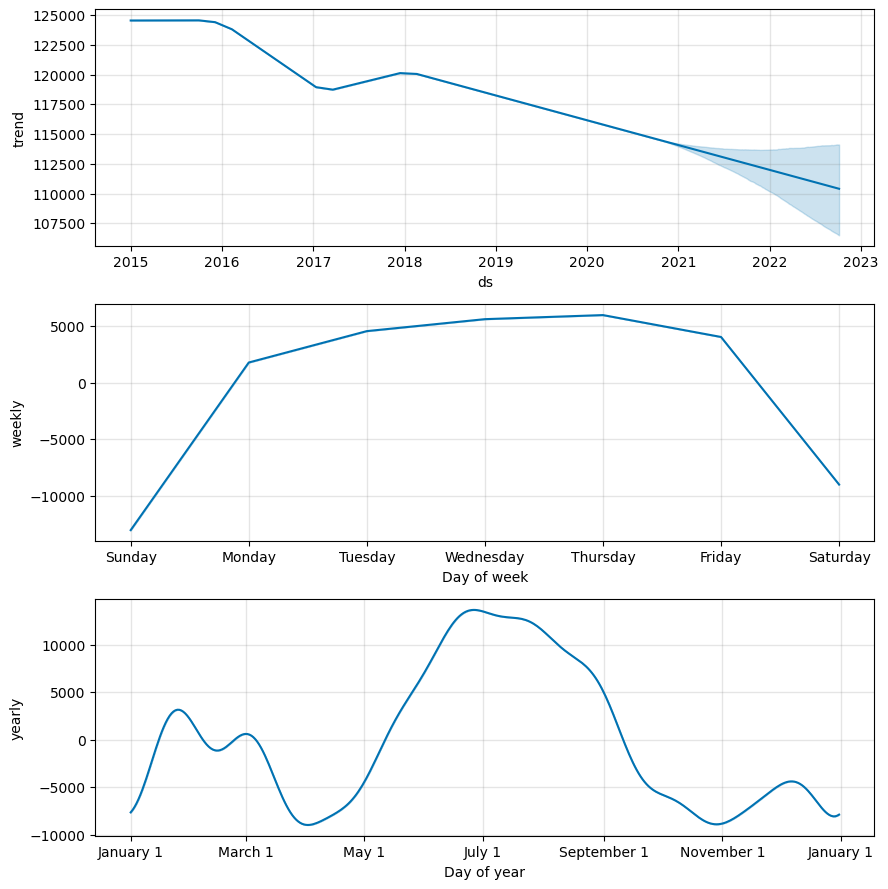

In [44]:
fig2 = model.plot_components(forecast)
plt.show()

## Future forecast prediction for 5 years

In [46]:
df_prophet = df[['date', 'demand']].copy()
df_prophet.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [47]:
model = Prophet()
model.fit(df_prophet)

17:17:49 - cmdstanpy - INFO - Chain [1] start processing
17:17:49 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
future = model.make_future_dataframe(periods=1825)

In [49]:
forecast = model.predict(future)

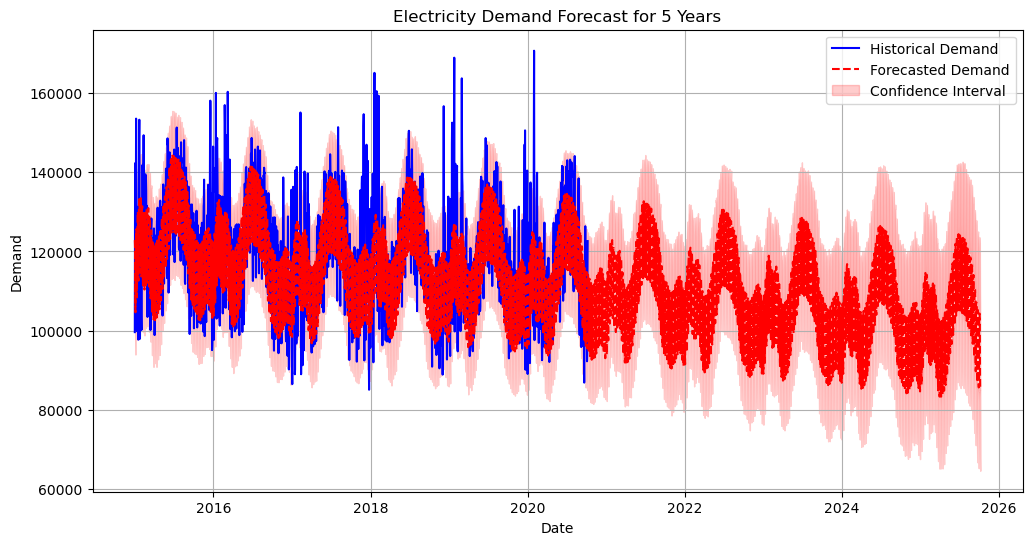

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_prophet['ds'], df_prophet['y'], label='Historical Demand', color='blue')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecasted Demand', color='red', linestyle='dashed')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2, label='Confidence Interval')
ax.set_title("Electricity Demand Forecast for 5 Years")
ax.set_xlabel("Date")
ax.set_ylabel("Demand")
ax.legend()
plt.grid()
plt.show()

In [51]:
def forecast_demand(model, days):
    future = model.make_future_dataframe(periods=days, freq='D')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(days)
num_days = int(input("Enter the number of days for forecast: "))
forecast_result = forecast_demand(model, num_days)
print(forecast_result)

Enter the number of days for forecast:  1825


             ds           yhat     yhat_lower     yhat_upper
2106 2020-10-07  113896.214184  102311.579645  124706.646475
2107 2020-10-08  114141.499098  103009.233372  124734.783498
2108 2020-10-09  112077.292163  101626.738801  123444.695595
2109 2020-10-10   98871.830879   87625.645776  110088.883043
2110 2020-10-11   94689.909069   83655.045877  106089.669423
...         ...            ...            ...            ...
3926 2025-10-01  104046.366646   85740.138625  124426.296147
3927 2025-10-02  104317.376438   85990.341980  124622.699093
3928 2025-10-03  102289.690569   83721.226300  122243.168036
3929 2025-10-04   89128.940921   69698.540344  109132.244339
3930 2025-10-05   84997.170116   66065.353944  105244.655463

[1825 rows x 4 columns]


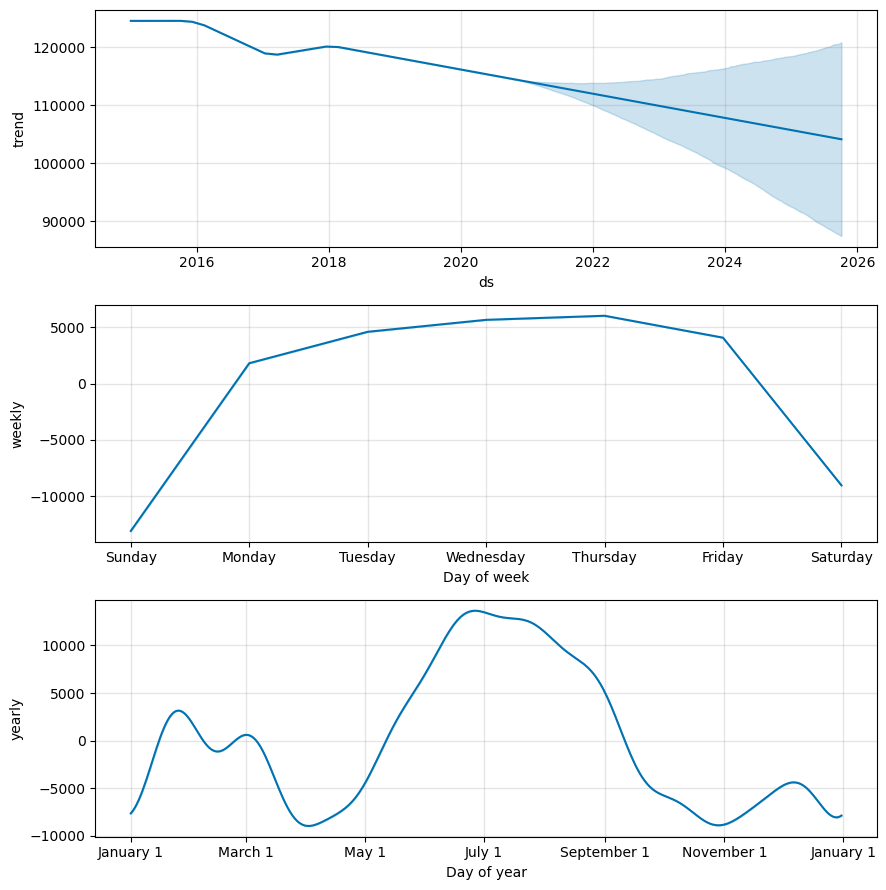

In [52]:
fig2 = model.plot_components(forecast)
plt.show()

In [53]:
import joblib

# Assuming `model` is your trained Prophet model
joblib.dump(model, 'prophet_model.pkl')

['prophet_model.pkl']